
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [1]:
# The next 8 lines added to be compatible with version changes (2022/10/13).
# change cuda to 11.1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"
# change pytorch to 1.9.0 compiled with cuda 11.1
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [2]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

/content
'=2.0.1'   drive   sample_data
Thu Mar  2 00:28:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [3]:
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from torchsummary import summary
from tqdm.notebook import tqdm
from glob import glob
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
import copy
# import some common detectron2 utilities
import detectron2
from detectron2.data import detection_utils as utils
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import transforms as T
setup_logger()


<Logger detectron2 (DEBUG)>

In [4]:
# Make sure that GPU is available for your notebook. 
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
torch.cuda.is_available()

True

In [5]:
# You need to mount your google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
BASE_DIR = '/content/drive/My Drive/CMPT_CV_lab3'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
!ls

'=2.0.1'   drive   sample_data


## Part 1: Object Detection

### Data Loader

In [23]:
import enum
'''
# This function should return a list of data samples in which each sample is a dictionary. 
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''

def train(set_name, eval_size = 0):
  data_dirs = f'{BASE_DIR}/data/train.json'
  with open(data_dirs) as j:
      imgs_anns = json.load(j)
  dataset_dicts={}
  for idx, v in enumerate(tqdm(imgs_anns)):
      filename = os.path.join(f'{BASE_DIR}/data/train', v["file_name"])
      annotations = v["segmentation"]
      px = [annotations[0][i] for i in range(0, len(annotations[0]), 2)]
      py = [annotations[0][i] for i in range(1, len(annotations[0]), 2)]
      poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
      poly = [p for x in poly for p in x]
      obj = {
          "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": [poly],
          "category_id": 0,
      }
      if not filename in dataset_dicts:
          dataset_dicts[filename] = {}
          dataset_dicts[filename]['annotations'] = []
          width, height = Image.open(filename).size
          dataset_dicts[filename]['file_name'] = filename
          dataset_dicts[filename]['image_id'] = idx
          dataset_dicts[filename]['height'] = int(height)
          dataset_dicts[filename]['width'] = int(width)
      dataset_dicts[filename]['annotations'].append(obj)
  dataset_dicts = np.array(list(dataset_dicts.values()))
  vals = np.random.choice(dataset_dicts.shape[0], eval_size)
  return dataset_dicts, vals 

dataset_dic, vals = train('train.json', 30)



def get_detection_data(set_name):
  if set_name == 'validation.json':
    return dataset_dic[vals].tolist()

  if set_name == 'test.json':
      dataset_dicts = []
      for f in tqdm(glob(f'{BASE_DIR}/data/test/*')):
          entry = {}
          width, height = Image.open(f).size
          entry['file_name'] = f
          entry['height'] = int(height)
          entry['width'] = int(width)
          entry['annotations'] = []
          dataset_dicts.append(entry)
      return dataset_dicts
  else:
    train_dataset = np.delete(dataset_dic, vals)
    return train_dataset.tolist()


  0%|          | 0/7980 [00:00<?, ?it/s]

In [8]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''
#DatasetCatalog.clear()
#MetadataCatalog.clear()
for d in ["train","test",'validation']:
    DatasetCatalog.register("plane_" + d, lambda d=d: get_detection_data(d+'.json'))
    MetadataCatalog.get("plane_" + d).set(thing_classes=["planes"])
planes_metadata = MetadataCatalog.get("plane_train")


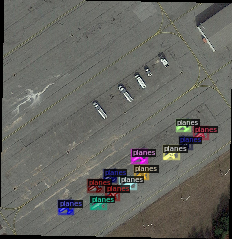

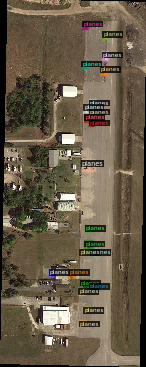

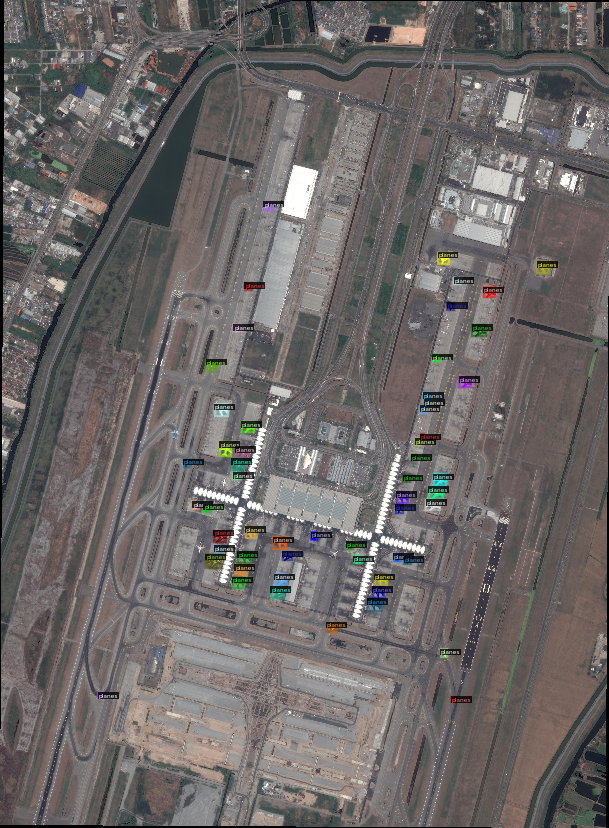

In [9]:
'''
# Visualize some samples using Visualizer to make sure that the function works correctly
# TODO: approx 5 lines
'''
dataset_dicts = get_detection_data("train.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=planes_metadata, scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])


### Set Configs

In [13]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''

cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("plane_train",)
cfg.DATASETS.TEST = ("plane_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")#("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml") # Let training initialize from model zoo  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.



### Training

In [14]:
'''
# Create a DefaultTrainer using the above config and train the model
# TODO: approx 5 lines
'''

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[03/02 00:35:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/02 00:35:15 d2.engine.train_loop]: Starting training from iteration 0
[03/02 00:35:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7efaced38d30> to CPU due to CUDA OOM
[03/02 00:36:09 d2.utils.events]:  eta: 0:32:50  iter: 19  total_loss: 3.366  loss_cls: 0.6818  loss_box_reg: 0.2594  loss_rpn_cls: 1.991  loss_rpn_loc: 0.4101  time: 2.5273  data_time: 0.4181  lr: 9.9905e-06  max_mem: 12134M
[03/02 00:36:49 d2.utils.events]:  eta: 0:32:10  iter: 39  total_loss: 1.647  loss_cls: 0.6091  loss_box_reg: 0.2543  loss_rpn_cls: 0.4558  loss_rpn_loc: 0.3029  time: 2.2403  data_time: 0.1963  lr: 1.998e-05  max_mem: 12134M
[03/02 00:37:30 d2.utils.events]:  eta: 0:30:55  iter: 59  total_loss: 1.486  loss_cls: 0.4964  loss_box_reg: 0.2877  loss_rpn_cls: 0.2632  loss_rpn_loc: 0.3644  time: 2.1762  data_time: 0.2993  lr: 2.997e-05  max_mem: 12134M
[03/02 00:38:06 d2.utils.events]:  eta: 0:29:51  iter: 79  total_loss: 1.265  loss_cls: 0.3705  loss_box_reg: 0.2439  lo

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efb30863670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[03/02 00:58:07 d2.utils.events]:  eta: 0:11:34  iter: 639  total_loss: 0.8328  loss_cls: 0.1949  loss_box_reg: 0.3351  loss_rpn_cls: 0.08855  loss_rpn_loc: 0.1882  time: 2.1356  data_time: 0.2243  lr: 0.00031968  max_mem: 12454M
[03/02 00:58:45 d2.utils.events]:  eta: 0:10:56  iter: 659  total_loss: 0.862  loss_cls: 0.1943  loss_box_reg: 0.2515  loss_rpn_cls: 0.1003  loss_rpn_loc: 0.2439  time: 2.1288  data_time: 0.2108  lr: 0.00032967  max_mem: 12454M
[03/02 00:59:24 d2.utils.events]:  eta: 0:10:17  iter: 679  total_loss: 0.786  loss_cls: 0.1915  loss_box_reg: 0.3253  loss_rpn_cls: 0.08117  loss_rpn_loc: 0.1932  time: 2.1227  data_time: 0.1634  lr: 0.00033966  max_mem: 12454M
[03/02 00:59:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7efaced38d30> to CPU due to CUDA OOM
[03/02 01:00:09 d2.utils.events]:  eta: 0:09:38  iter: 699  total_loss: 0.6966  loss_cls: 0.1616  loss_box_reg: 0.2919  loss_rpn_cls: 0.08797  loss_rpn_loc: 0.2098  time: 2.1276  data_t

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efb30863670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[03/02 01:07:53 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7efaced38d30> to CPU due to CUDA OOM
[03/02 01:08:04 d2.utils.events]:  eta: 0:02:32  iter: 919  total_loss: 0.7188  loss_cls: 0.1531  loss_box_reg: 0.2526  loss_rpn_cls: 0.06676  loss_rpn_loc: 0.2131  time: 2.1346  data_time: 0.2511  lr: 0.00045954  max_mem: 12454M
[03/02 01:08:44 d2.utils.events]:  eta: 0:01:54  iter: 939  total_loss: 0.782  loss_cls: 0.1745  loss_box_reg: 0.3242  loss_rpn_cls: 0.06157  loss_rpn_loc: 0.1744  time: 2.1313  data_time: 0.1988  lr: 0.00046953  max_mem: 12454M
[03/02 01:09:24 d2.utils.events]:  eta: 0:01:16  iter: 959  total_loss: 0.671  loss_cls: 0.1394  loss_box_reg: 0.279  loss_rpn_cls: 0.05536  loss_rpn_loc: 0.2029  time: 2.1292  data_time: 0.2340  lr: 0.00047952  max_mem: 12454M
[03/02 01:10:05 d2.utils.events]:  eta: 0:00:38  iter: 979  total_loss: 0.6292  loss_cls: 0.1468  loss_box_reg: 0.2681  loss_rpn_cls: 0.0616  loss_rpn_loc: 0.1602  time: 2.1268  data_ti

  0%|          | 0/72 [00:00<?, ?it/s]

[03/02 01:10:55 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   planes   | 0            |
|            |              |
[03/02 01:10:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/02 01:10:55 d2.data.common]: Serializing 72 elements to byte tensors and concatenating them all ...
[03/02 01:10:55 d2.data.common]: Serialized dataset takes 0.01 MiB
WARNING [03/02 01:10:55 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


### Evaluation and Visualization

In [16]:
%load_ext tensorboard
%tensorboard --logdir drive/My\ Drive/CMPT_CV_lab3/output

<IPython.core.display.Javascript object>

In [17]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [20]:
'''
# Visualize the output for 3 random test samples
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_detection_data("test.json")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=planes_metadata, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [25]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''
dataset_dic = get_detection_data("validation.json")
evaluator = COCOEvaluator("plane_validation", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "plane_validation")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


TypeError: ignored

### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [ ]:
'''
# Bring any changes and updates regarding the improvement in here
'''


## Part 2: Semantic Segmentation

### Data Loader

In [ ]:
training_data = get_detection_data('train')

In [87]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask 
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import GenericMask

from google.colab.patches import cv2_imshow


def get_instance_sample(data, img=None):
  filename = data['file_name']
  image = cv2.imread(filename)
  dicts = {'img': [], 'mask':[]}
  for idx in range(len(data['annotations'])):
      annots = data['annotations'][idx]
      bbox = annots['bbox']
      x_min,y_min,x_max,y_max = [int(i) for i in bbox]
      obj_img = img[y_min:y_max, x_min:x_max]
      obj_mask = detectron2.utils.visualizer.GenericMask(data["annotations"][idx]["segmentation"], data['height'], data['width']).mask
      obj_mask = obj_mask[y_min:y_max, x_min:x_max]*255
      obj_img = cv2.resize(obj_img, (128, 128), interpolation = cv2.INTER_AREA) 
      obj_mask = cv2.resize(obj_mask, (128, 128), interpolation = cv2.INTER_AREA)
      dicts['img'].append(obj_img)
      dicts['mask'].append(obj_mask)
  return dicts

In [88]:
m = get_detection_data('train')
data = {'img':[], 'masks':[]}
for i in tqdm(m):
    #print(i["file_name"])
    fname = i["file_name"].split('/')[-1].split('.')[0]
    dic = get_instance_sample(i)
    data['img']+=[dic['img']]
    data['masks']+=[dic['mask']]



  0%|          | 0/198 [00:00<?, ?it/s]

In [ ]:
'''
import h5py
data_dirs = '{}/data'.format(BASE_DIR)
hdf5_path = f"{data_dirs}/planes.hdf5"  # path for .hdf5 file
train_img_path = f"{data_dirs}/train"

def create_h5_dataset():
  num_bbox = len(instance_map)

  train_X_shape = (num_bbox, 128, 128, 3)
  train_Y_shape = (num_bbox, 128, 128, 1)

  # open a hdf5 file
  f = h5py.File(hdf5_path, mode='w')

  f.create_dataset("train_X", train_X_shape, np.uint8)
  f.create_dataset("train_Y", train_Y_shape, np.uint8)

  # f.create_dataset("train_labels", (len(train_labels),), np.uint8)
  # f["train_labels"][...] = train_labels

  i = 0
  for idx in instance_map:

    if i % 10 == 0 and i > 1:
      print(f'Serializing train data: {i}')
      break

    if torch.is_tensor(idx):
        idx = idx.tolist()
    data = train_labels[idx[0]]
    img, mask = get_instance_sample(data, idx[1])

    f['train_X'][i, ...] = img
    f['train_Y'][i, ...] = mask

    i+=1

  f.close()

create_h5_dataset()

In [92]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''

class PlaneDataset(Dataset):
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
      ])
      self.set_name = set_name
      self.data = data_list
      self.instance_map = []
      for i, d in enumerate(self.data):
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j])

  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
        mask = self.transforms(mask)
    img = torch.as_tensor(img, dtype=torch.float)
    mask = torch.as_tensor(mask, dtype=torch.float)
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx = self.instance_map[idx]
    obj_mask = data['masks'][idx[0]][idx[1]]
    obj_img = data['img'][idx[0]][idx[1]]
    img, mask = self.numpy_to_tensor(obj_img, obj_mask)    
    return img, mask

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("plane_{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                              pin_memory=True, shuffle=True)
    return loader, dataset

### Network

In [33]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             nn.ReLU(inplace=True)
          )
        else:
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1)  
             )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
            )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y

'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Encoder
        
        self.input_conv = conv(3, 8)
        self.down_1 = down(8, 16)
        self.down_2 = down(16, 32)
        self.down_3 = down(32, 64)
        self.down_4 = down(64, 128)
        self.down_5 = down(128, 256)
        self.down_6 = down(256, 512)
        
        # Decoder

        self.up_1 = up(512, 256)
        self.up_2 = up(256, 128)
        self.up_3 = up(128, 64)
        self.up_4 = up(64, 32)
        self.up_5 = up(32, 16)
        self.up_6 = up(16, 8)
        self.up_7 = conv(8, 3)
        self.output_conv = conv(3, 1, False) # ReLu activation is removed to keep the logits for the loss function
        
        self.normal_1 = nn.BatchNorm2d(8)
        self.normal_2 = nn.BatchNorm2d(16)
        self.normal_3 = nn.BatchNorm2d(32)
        self.normal_4 = nn.BatchNorm2d(64)
        self.normal_5 = nn.BatchNorm2d(128)
        self.normal_6 = nn.BatchNorm2d(256)

    def forward(self, input):
      y_1 = self.input_conv(input)
      y_2 = self.down_1(y_1)
      y_3 = self.down_2(y_2)
      y_4 = self.down_3(y_3)
      y_5 = self.down_4(y_4)
      y_6 = self.down_5(y_5)
      y_7 = self.down_6(y_6)
      y_7 = self.normal_6(F.relu(self.up_1(y_7) + y_6))
      y_6 = self.normal_5(F.relu(self.up_2(y_7) + y_5))
      y_5 = self.normal_4(F.relu(self.up_3(y_6) + y_4))
      y_4 = self.normal_3(F.relu(self.up_4(y_5) + y_3))
      y_3 = self.normal_2(F.relu(self.up_5(y_4) + y_2))
      y_2 = self.normal_1(F.relu(self.up_6(y_3) + y_1))
      y = self.up_7(y_2)
      output = self.output_conv(y)
      return output

In [ ]:
model = MyModel().cuda()
summary(model, (3,128, 128))

### Training

In [94]:
'''
# The following is a basic training procedure to train the network
# You need to update the code to get the best performance
# TODO: approx ? lines
'''

# Set the hyperparameters
num_epochs = 5
batch_size = 2
learning_rate = 0.01
weight_decay = 1e-5

model = MyModel() # initialize the model
model = model.cuda() # move the model to GPU
loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
crit = nn.BCEWithLogitsLoss() # Define the loss function
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD

# start the training procedure
for epoch in range(num_epochs):
  total_loss = 0
  for (img, mask) in tqdm(loader):
    img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
    mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)
    pred = model(img)
    loss = crit(pred, mask)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total_loss += loss.cpu().data
  print("Epoch: {}, Loss: {}".format(epoch, total_loss/len(loader)))
  torch.save(model.state_dict(), '{}/output/{}_segmentation_model.pth'.format(BASE_DIR, epoch))

'''
# Saving the final model
'''
torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))


  0%|          | 0/3990 [00:00<?, ?it/s]

<ipython-input-94-491ab1594667>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
<ipython-input-94-491ab1594667>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)


Epoch: 0, Loss: 0.25233665108680725


  0%|          | 0/3990 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.20157670974731445


  0%|          | 0/3990 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.1882886439561844


  0%|          | 0/3990 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.17804303765296936


  0%|          | 0/3990 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.17035916447639465


### Evaluation and Visualization

In [95]:
'''
# Before starting the evaluation, you need to set the model mode to eval
# You may load the trained model again, in case if you want to continue your code later
# TODO: approx 15 lines
'''
batch_size = 1
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval() 
loader, dataset = get_plane_dataset('train', batch_size)

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def iou_coef(y_true, y_pred):
  y_true = np.rint(sigmoid(y_true))
  y_pred = np.rint(sigmoid(y_pred))
  intersection = np.count_nonzero(np.multiply(y_true, y_pred))
  union = np.count_nonzero(y_true+y_pred)
  if union == 0:
      return 0
  return intersection/union


total_iou = 0
count = 0
for (img, mask) in tqdm(loader):
  with torch.no_grad():
    img = img.cuda()
    mask = mask.cpu().detach()
    pred = model(img).cpu().detach()
    for i in range(img.shape[0]):
        predicted = np.array(pred[i])[0]
        masked = np.array(mask[i])[0]
        count+=1
        total_iou+=iou_coef(masked, predicted)
  '''
  ## Complete the code by obtaining the IoU for each img and print the final Mean IoU
  '''
    

print("\n #images: {}, Mean IoU: {}".format(count, total_iou/count))


  0%|          | 0/7980 [00:00<?, ?it/s]


 #images: 7980, Mean IoU: 0.7936116424699577


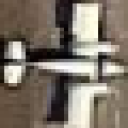

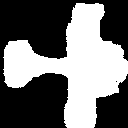

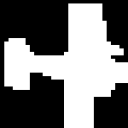

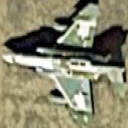

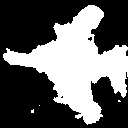

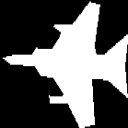

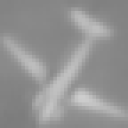

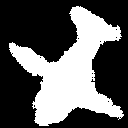

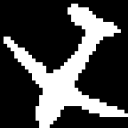

In [96]:
'''
# Visualize 3 sample outputs
# TODO: approx 5 lines
'''
batch_size = 3
loader, dataset = get_plane_dataset('train', batch_size)

img, mask = next(iter(loader))
with torch.no_grad():
    img = img.cuda()
    mask = mask.cpu().detach()
    pred = model(img).cpu().detach()
    for i in range(img.shape[0]):
        newimg = transforms.ToPILImage()(img[i].cpu())
        cv2_imshow(np.array(newimg))
        predicted = np.rint(sigmoid(np.array(pred[i])[0]))*255
        masked = np.array(mask[i])[0]*255
        cv2_imshow(predicted)
        cv2_imshow(masked)

## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

In [31]:
dataset_dic[0]['annotations'][0]['bbox']


[1369, 4510, 1485, 4625]

In [ ]:
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))

### Get Prediction

In [99]:
'''
# Define a new function to obtain the prediction mask by passing a sample data
# For this part, you need to use all the previous parts (predictor, get_instance_sample, data preprocessings, etc)
# It is better to keep everything (as well as the output of this funcion) on gpu as tensors to speed up the operations.
# pred_mask is the instance segmentation result and should have different values for different planes.
# TODO: approx 35 lines
'''

def sigmoid(x):
  return 1/(1 + np.exp(-x))


def get_prediction_mask(my_data, train=False):
  img = cv2.imread(my_data['file_name'])
  if train:
      pred_masks = np.zeros([my_data['height'], my_data['width']])
      imgs = []

      for i,j in enumerate(my_data['annotations']):
          bbox = j['bbox']
          y1, x1, y2, x2 = bbox
          to_be_masked = img[x1:x2, y1:y2]
          to_be_masked = cv2.resize(to_be_masked, (128, 128), interpolation = cv2.INTER_AREA) # Resizing to make sure it matches our expected 
          prediction_from_mask = model(torch.unsqueeze(torch.tensor(transforms.ToTensor()(to_be_masked), device=torch.device('cuda')),0)).cpu().detach().numpy()[0] # Getting a mask prediction from my trained model
          prediction_from_mask = cv2.resize(prediction_from_mask[0], (y2-y1, x2-x1), interpolation = cv2.INTER_AREA) # Reshaping to the original shape
          prediction_from_mask = np.rint(sigmoid(prediction_from_mask))*(i+1)
          predicted_mask = pred_masks[x1:x2, y1:y2]
          predicted_mask[predicted_mask==0] = 10000
          overlapping = np.minimum(predicted_mask,prediction_from_mask)
          overlapping[overlapping == 1000] = 0
          pred_masks[x1:x2, y1:y2] = overlapping # set the masking of the location
  else:
      prediction_for_img = predictor(img)['instances'] # use the model from part 1 to get the bounding boxes
      pred_masks = np.zeros([my_data['height'], my_data['width']])
      imgs = []
      # Getting the bounding boxes from the pretrained model and 
      # Segmentation from the other model
      for i in range(len(prediction_for_img)):
          bbox = np.array(np.floor(list(prediction_for_img[i]._fields['pred_boxes'])[0].cpu().numpy()), dtype=np.uint32) # Getting the bounding boxes
          y1, x1, y2, x2 = bbox
          to_be_masked = img[x1:x2, y1:y2]
          to_be_masked = cv2.resize(to_be_masked, (128, 128), interpolation = cv2.INTER_AREA) # Resizing to make sure it matches our expected 
          prediction_from_mask = model(torch.unsqueeze(torch.tensor(transforms.ToTensor()(to_be_masked), device=torch.device('cuda')),0)).cpu().detach().numpy()[0] # Getting a mask prediction from my trained model
          prediction_from_mask = cv2.resize(prediction_from_mask[0], (y2-y1, x2-x1), interpolation = cv2.INTER_AREA) # Reshaping to the original shape
          prediction_from_mask = np.rint(sigmoid(prediction_from_mask))*(i+1)
          predicted_mask = pred_masks[x1:x2, y1:y2]
          predicted_mask[predicted_mask==0] = 10000
          overlapping = np.minimum(predicted_mask,prediction_from_mask)
          overlapping[overlapping == 1000] = 0
          pred_masks[x1:x2, y1:y2] = overlapping # set the masking of the location

  # Getting the true segementations from the data
  true_mask = np.zeros([my_data['height'], my_data['width']])
  for j,i in enumerate(my_data['annotations']):
      bbox = i['bbox']
      y1, x1, y2, x2 = [int(i) for i in bbox]
      x2 +=x1
      y2 += y1
      local_true_mask = detectron2.utils.visualizer.GenericMask(i['segmentation'], my_data['height'], my_data['width']).mask
      overlapping = np.maximum(true_mask[x1:x2, y1:y2],local_true_mask[x1:x2, y1:y2]*(j+1))
      true_mask[x1:x2, y1:y2] = overlapping
  return img, torch.tensor(true_mask, device=torch.device('cuda')), torch.tensor(pred_masks, device=torch.device('cuda'))


### Visualization and Submission

In [ ]:
'''
# Visualise the output prediction as well as the GT Mask and Input image for a sample input
# TODO: approx 10 lines
'''
dataset = get_detection_data('train.json')
for i in np.random.randint(0,50,3):
  img, true_mask, pred_mask = get_prediction_mask(dataset[i])
  pred_mask = pred_mask.cpu().numpy()
  true_mask = true_mask.cpu().numpy()
  max_val = pred_mask.max()
  fact = 255./max_val
  pred_mask*= fact
  max_val = true_mask.max()
  fact = 255./max_val
  true_mask*= fact
  cv2_imshow(cv2.resize(img, (img.shape[1]//3, img.shape[0]//3), interpolation = cv2.INTER_AREA))
  cv2_imshow(cv2.resize(true_mask, (true_mask.shape[1]//3, true_mask.shape[0]//3), interpolation = cv2.INTER_AREA))
  cv2_imshow(cv2.resize(pred_mask, (pred_mask.shape[1]//3, pred_mask.shape[0]//3), interpolation = cv2.INTER_AREA))


In [101]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [104]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
my_data_list = DatasetCatalog.get("plane_{}".format('train'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

'''
# Writing the predictions of the test set
'''

my_data_list = DatasetCatalog.get("plane_{}".format('test'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()


  0%|          | 0/198 [00:00<?, ?it/s]

<ipython-input-99-b0c74222dea1>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_from_mask = model(torch.unsqueeze(torch.tensor(transforms.ToTensor()(to_be_masked), device=torch.device('cuda')),0)).cpu().detach().numpy()[0] # Getting a mask prediction from my trained model


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

In [ ]:
dataset_dic, vals = train('train.json', 10) # for validation

for d in ["train","test",'validation']:
    DatasetCatalog.register("plane_" + d, lambda d=d: get_detection_data(d+'.json'))
    MetadataCatalog.get("plane_" + d).set(thing_classes=["planes"])
planes_metadata = MetadataCatalog.get("plane_train")

### Network

In [27]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("plane_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.OUTPUT_DIR = f"{BASE_DIR}/output/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


### Training

In [28]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/02 01:17:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/02 01:17:02 d2.engine.train_loop]: Starting training from iteration 0
[03/02 01:17:30 d2.utils.events]:  eta: 0:06:47  iter: 19  total_loss: 2.722  loss_cls: 0.627  loss_box_reg: 0.4006  loss_mask: 0.6877  loss_rpn_cls: 0.6477  loss_rpn_loc: 0.3685  time: 1.2759  data_time: 0.7227  lr: 7.7924e-05  max_mem: 12454M
[03/02 01:17:50 d2.utils.events]:  eta: 0:06:09  iter: 39  total_loss: 2.074  loss_cls: 0.388  loss_box_reg: 0.3483  loss_mask: 0.6439  loss_rpn_cls: 0.2928  loss_rpn_loc: 0.3141  time: 1.1487  data_time: 0.3551  lr: 0.00015784  max_mem: 12454M
[03/02 01:18:08 d2.utils.events]:  eta: 0:06:10  iter: 59  total_loss: 1.924  loss_cls: 0.3724  loss_box_reg: 0.4738  loss_mask: 0.5569  loss_rpn_cls: 0.2169  loss_rpn_loc: 0.2009  time: 1.0555  data_time: 0.2286  lr: 0.00023776  max_mem: 12454M
[03/02 01:18:26 d2.utils.events]:  eta: 0:05:43  iter: 79  total_loss: 1.71  loss_cls: 0.2562  loss_box_reg: 0.3676  loss_mask: 0.5  loss_rpn_cls: 0.2043  loss_rpn_loc: 0.2695  time: 1.0143 

### Evaluation and Visualization

In [29]:
dataset_dicts = get_detection_data("validation.json")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=planes_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [30]:
evaluator = COCOEvaluator("plane_validation", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "plane_validation")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [03/02 01:27:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/02 01:27:18 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   planes   | 493          |
|            |              |
[03/02 01:27:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/02 01:27:18 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[03/02 01:27:18 d2.data.common]: Serialized dataset takes 3.26 MiB
[03/02 01:27:18 d2.evaluation.evaluator]: Start inference on 10 batches
[03/02 01:28:07 d2.evaluation.evaluator]: Total inference time: 0:00:23.678865 (4.735773 s / iter per device, on 1 devices)
[03/02 01:28:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00: